In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import ast

In [3]:
!pip install opendatasets --quiet

In [4]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/competitions/tutors-lessons-prices-prediction'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: grigorysedov
Your Kaggle Key: ··········


100%|██████████| 2.56M/2.56M [00:00<00:00, 105MB/s]


Extracting archive ./tutors-lessons-prices-prediction/tutors-lessons-prices-prediction.zip to ./tutors-lessons-prices-prediction


In [53]:
train = pd.read_excel('/content/tutors-lessons-prices-prediction/train.xlsx')
test = pd.read_excel('/content/tutors-lessons-prices-prediction/test.xlsx')
sample_submit = pd.read_csv('/content/tutors-lessons-prices-prediction/sample_submit.csv')

In [54]:
def transform(df):
  df.drop('Unnamed: 0', axis=1, inplace=True)
  df.drop('ФИО', axis=1, inplace=True)
  df.drop('description', axis=1, inplace=True)
  df.drop('experience_desc', axis=1, inplace=True)
  df.drop([f'Desc_Education_{i}' for i in range(1, 7)], axis=1, inplace=True)

  df['categories'] = df['categories'].apply(lambda s: list(ast.literal_eval(s)))
  mlb = MultiLabelBinarizer()
  categories_encoded = mlb.fit_transform(df['categories'])
  categories_df = pd.DataFrame(categories_encoded, columns=mlb.classes_)
  df = pd.concat([df, categories_df], axis=1)
  df.drop('categories', axis=1, inplace=True)

  df['tutor_head_tags'] = df['tutor_head_tags'].apply(lambda s: list(ast.literal_eval(s)))
  mlb = MultiLabelBinarizer()
  categories_encoded = mlb.fit_transform(df['tutor_head_tags'])
  categories_df = pd.DataFrame(categories_encoded, columns=mlb.classes_)
  df = pd.concat([df, categories_df], axis=1)
  df.drop('tutor_head_tags', axis=1, inplace=True)

  df.drop('tutor_reviews', axis=1, inplace=True) # may be
  df = pd.get_dummies(df, columns=['предмет'], dtype=int)
  df = pd.concat([df, df.status.str.get_dummies(sep=',')], axis=1)
  df.drop('status', axis=1, inplace=True)
  for i in range(1, 3):
    s1 = f'Ученая степень {i}'
    df.loc[df[s1].notnull(), s1] = 1
    df.loc[df[s1].isnull(), s1] = 0
    s2 = f'Ученое звание {i}'
    df.loc[df[s2].notnull(), s2] = 1
    df.loc[df[s2].isnull(), s2] = 0
  ed_sum = sum([df[f'Education_{i}'].map(pd.notnull) for i in range(1, 7)])
  df.insert(2, 'educations', ed_sum.astype(int))
  df = df.drop([f'Education_{i}' for i in range(1, 7)], axis=1)
  sum_sc = df['Ученая степень 1'] + df['Ученая степень 2'] + df['Ученое звание 1'] + df['Ученое звание 2']
  df.insert(2, 'science_rating', sum_sc.astype(int))
  df = df.drop(['Ученая степень 1', 'Ученая степень 2', 'Ученое звание 1', 'Ученое звание 2'], axis=1)
  df['experience'] = df['experience'].str.replace(r"[^\d\.]", "", regex=True).astype(float)
  df.loc[df.experience.isnull(), 'experience'] = 0
  df.loc[df.tutor_rating.isnull(), 'tutor_rating'] = 0
  return df

In [55]:
train = transform(train)
# train = train[[c for c in train if c != 'mean_price'] + ['mean_price']]
# train = train[train['mean_price'] < 35] # выпиливаем отклонения
# train = train[train['mean_price'] > 2] # выпиливаем отклонения
train

,tutor_rating,educations,science_rating,experience,mean_price,Взрослые кроме абитуриентов и студентов,Взрослые кроме абитуриентов и студентов в паре,Взрослые кроме абитуриентов и студентов группа,Дошкольники,Дошкольники в паре,...,Теория вероятности и мат. статистика,Уравнения мат физики,Школьная программа,предмет_informatika,предмет_matematika,Аспирант или ординатор очной формы обучения,Студент,Университетский преподаватель,Частный преподаватель,Школьный преподаватель
0,5.0,1,0,31.0,16.666667,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0
1,4.0,2,0,8.0,11.666667,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
2,0.0,3,0,11.0,23.333333,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
3,4.0,1,0,5.0,0.116667,1,0,0,0,0,...,1,0,1,0,1,0,0,0,1,0
4,0.0,1,0,19.0,16.666667,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4543,4.0,1,0,5.0,16.666667,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
4544,0.0,1,0,30.0,33.333333,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
4545,0.0,1,0,6.0,23.333333,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
4546,0.0,1,0,1.0,9.722222,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0


<Axes: >

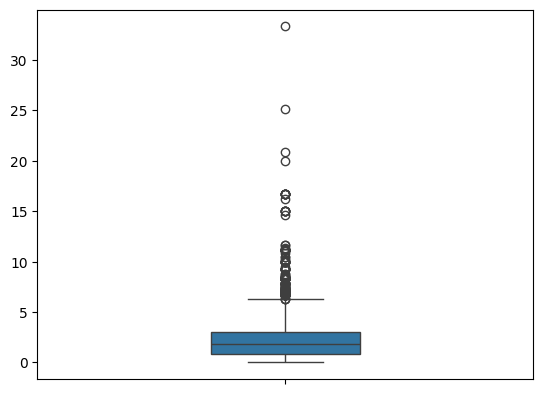

In [56]:
# train = train[train['mean_price'] / (train['experience'] + 1) < 6] # выпиливаем отклонения
sns.boxplot(train['mean_price'] / (train['experience'] + 1), width=0.3)

In [57]:
X = train.drop(columns=['mean_price'])
Y = train['mean_price']
print(X.shape, Y.shape)

(4548, 47) (4548,)


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Test dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (3183, 47), (3183,)
Test dataset size: (1365, 47), (1365,)


In [69]:
lin_reg = LinearRegression()
lin_reg.fit(X, Y)

LinearRegression()

In [70]:
y_pred = lin_reg.predict(X_test)

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R2 score:', r2_score(y_test, y_pred))

Mean Absolute Error: 6.899341776148083
Mean Squared Error: 88.35033816542868
R2 score: 0.20608081773292208


In [71]:
test = transform(test)
x_test = test.iloc[:, :].values

In [72]:
y_test = lin_reg.predict(x_test)
submition = pd.DataFrame(y_test, columns=['mean_price'])
submition = submition.reset_index()
print(submition.shape)
submition.to_csv('submission.csv', index=False)

(1516, 2)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [186]:
submition

,index,mean_price
0,0,34.337089
1,1,29.434861
2,2,23.338457
3,3,30.802692
4,4,15.726125
...,...,...
1511,1511,-4.170701
1512,1512,23.380718
1513,1513,15.937233
1514,1514,18.291397
